In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from scipy.stats import rankdata
from scipy import interpolate


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent.parent
print(PATH_ROOT)


/home/lukec/workspace/applicabilityDomain


In [3]:
DEFENSES = [
    'delta',
    'gamma',
    'kappa',
    'boundingbox',
    'prob',
]
DEFENSES_ALIAS = {
    'delta': 'DM-δ',
    'gamma': 'DM-γ',
    'kappa': 'DM-κ',
    'boundingbox': 'BB',
    'prob': 'Prob.',
}
DATASETS = [
    "abalone",
    "australian",
    "banknote",
    "breastcancer",
    "htru2",
    "phoneme",
    "ringnorm",
    "texture",
]
ATTACKS = [
    'fgsm',
    'apgd',
]
EPSILONS = [
    '0.300',
    '0.600',
]
ATTACKS_C = ['cw2']
PARAM_C = [
    '0.000',
    '10.000',
]


In [4]:
def get_data_path(defense, dataset, attack, eps):
    name = f'roc_mean_{defense}_{dataset}_{attack}_{eps}.csv'
    return os.path.join(PATH_ROOT, 'results', 'numeric', 'mean', name)


df = pd.read_csv(get_data_path(DEFENSES[0], DATASETS[2], ATTACKS[0], EPSILONS[0]))
df


,fpr_0,tpr_0,fpr_1,tpr_1,fpr_2,tpr_2,fpr_3,tpr_3,fpr_4,tpr_4
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.003636,0.000000,0.003636,0.003636,0.000000,0.003636,0.000000,0.000000,0.003636
2,0.007273,0.003636,0.000000,0.007273,0.003636,0.003636,0.003636,0.007273,0.003636,0.003636
3,0.007273,0.010909,0.003636,0.007273,0.007273,0.003636,0.007273,0.007273,0.003636,0.036364
4,0.018182,0.010909,0.003636,0.014545,0.007273,0.040000,0.007273,0.025455,0.007273,0.036364
...,...,...,...,...,...,...,...,...,...,...
196,0.920000,0.992727,0.810909,0.992727,0.687273,0.967273,0.738182,0.978182,NaN,NaN
197,0.920000,0.996364,0.880000,0.992727,0.723636,0.967273,0.763636,0.978182,NaN,NaN
198,0.952727,0.996364,0.880000,0.996364,0.723636,0.970909,0.763636,0.981818,NaN,NaN
199,0.952727,1.000000,0.981818,0.996364,0.730909,0.970909,0.785455,0.981818,NaN,NaN


In [5]:
def estimate_tpr(x, y, x_interp):
    """Interpolate ROC on an evenly spaced X values."""
    assert x.shape == y.shape
    # Fix start and finish points
    f = interpolate.interp1d(
        np.concatenate(([0], x, [1])),
        np.concatenate(([0], y, [1])))
    yy = f(x_interp)
    return yy


def compute_auc(df):
    """Compute ROC-AUC from a dataframe with repeated experiments."""
    columns = df.columns.to_numpy()
    columns_fpr = columns[[c[:len('fpr_')] == 'fpr_' for c in columns]]
    columns_tpr = columns[[c[:len('tpr_')] == 'tpr_' for c in columns]]
    df_fpr = df[columns_fpr]
    df_tpr = df[columns_tpr]
    _x = np.linspace(0.01, 0.99, num=100 - 2)
    _y = []
    n_col = len(df_fpr.columns)
    for i in range(n_col):
        fpr = df_fpr.iloc[:, i].to_numpy()
        tpr = df_tpr.iloc[:, i].to_numpy()
        yy = estimate_tpr(fpr, tpr, _x)
        _y.append(yy)
    _y = np.array(_y)
    y_mean = _y.mean(axis=0)
    # Add start and finish points
    fpr = np.concatenate(([0], _x, [1.]))
    tpr = np.concatenate(([0], y_mean, [1.]))
    auc_score = auc(fpr, tpr)
    return auc_score


In [6]:
compute_auc(df)


0.7996548437982521

In [7]:
df_results = pd.DataFrame({
    'Dataset': [],
    'Defense': [],
    'Attack': [],
    'Eps': [],
    'AUC': [],
    'Path': [],
})
index = ['Dataset', 'Defense', 'Attack', 'Eps', 'Path']
for dataset in DATASETS:
    for defense in DEFENSES:
        for att in ATTACKS:  # FGSM and APGD
            for eps in EPSILONS:
                data_path = get_data_path(defense, dataset, att, eps)
                row = pd.Series(
                    [dataset, DEFENSES_ALIAS[defense], att, eps, data_path],
                    index=index
                )
                df_results = df_results.append(row, ignore_index=True)
        
        for att in ATTACKS_C:  # CW2 runs different parameter
            for c in PARAM_C:
                data_path = get_data_path(defense, dataset, att, c)
                row = pd.Series(
                    [dataset, DEFENSES_ALIAS[defense], att, c, data_path],
                    index=index
                )
                df_results = df_results.append(row, ignore_index=True)


In [8]:
df_results


,Dataset,Defense,Attack,Eps,AUC,Path
0,abalone,DM-δ,fgsm,0.300,NaN,/home/lukec/workspace/applicabilityDomain/resu...
1,abalone,DM-δ,fgsm,0.600,NaN,/home/lukec/workspace/applicabilityDomain/resu...
2,abalone,DM-δ,apgd,0.300,NaN,/home/lukec/workspace/applicabilityDomain/resu...
3,abalone,DM-δ,apgd,0.600,NaN,/home/lukec/workspace/applicabilityDomain/resu...
4,abalone,DM-δ,cw2,0.000,NaN,/home/lukec/workspace/applicabilityDomain/resu...
...,...,...,...,...,...,...
235,texture,Prob.,fgsm,0.600,NaN,/home/lukec/workspace/applicabilityDomain/resu...
236,texture,Prob.,apgd,0.300,NaN,/home/lukec/workspace/applicabilityDomain/resu...
237,texture,Prob.,apgd,0.600,NaN,/home/lukec/workspace/applicabilityDomain/resu...
238,texture,Prob.,cw2,0.000,NaN,/home/lukec/workspace/applicabilityDomain/resu...


In [9]:
for i in range(len(df_results)):
    data_path = df_results.iloc[i]['Path']
    assert os.path.exists(data_path), f'{data_path} does not exist!'
    
    _df = pd.read_csv(data_path)
    auc_score = compute_auc(_df)
    df_results.at[i, 'AUC'] = auc_score

In [10]:
df_results

,Dataset,Defense,Attack,Eps,AUC,Path
0,abalone,DM-δ,fgsm,0.300,0.895318,/home/lukec/workspace/applicabilityDomain/resu...
1,abalone,DM-δ,fgsm,0.600,0.979034,/home/lukec/workspace/applicabilityDomain/resu...
2,abalone,DM-δ,apgd,0.300,0.852850,/home/lukec/workspace/applicabilityDomain/resu...
3,abalone,DM-δ,apgd,0.600,0.970965,/home/lukec/workspace/applicabilityDomain/resu...
4,abalone,DM-δ,cw2,0.000,0.671731,/home/lukec/workspace/applicabilityDomain/resu...
...,...,...,...,...,...,...
235,texture,Prob.,fgsm,0.600,0.573520,/home/lukec/workspace/applicabilityDomain/resu...
236,texture,Prob.,apgd,0.300,0.542699,/home/lukec/workspace/applicabilityDomain/resu...
237,texture,Prob.,apgd,0.600,0.221322,/home/lukec/workspace/applicabilityDomain/resu...
238,texture,Prob.,cw2,0.000,0.994982,/home/lukec/workspace/applicabilityDomain/resu...


In [11]:
path_output = os.path.join(PATH_ROOT, 'plot_results', 'numeric', 'numeric_roc_auc.csv')
if not os.path.exists(Path(path_output).parent):
    os.mkdir(Path(path_output).parent)
df_results.to_csv(path_output, index=False)

In [14]:
X_LBLS = [
    'FGSM: Low', 'FGSM: High', 'APGD: Low', 'APGD: High', 'CW2: Low', 'CW2: High',
]
def create_auc_heatmap(df, dataset, output, fontsize=12, figsize=(4.5, 4), x_lbls=X_LBLS):
    df_dataset = df[df['Dataset'] == dataset]
    heatmap_table = df_dataset.pivot(index='Defense', columns=['Attack', 'Eps'], values='AUC')
    # Use the same order as previous plots
    heatmap_table = heatmap_table.loc[list(DEFENSES_ALIAS.values())]

    plt.rc('font', size=fontsize)
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_table, 
                xticklabels=x_lbls,
                cmap='YlGn',
                annot=True, 
                fmt='.2f', 
                cbar=False,
                vmin=0.5,
                vmax=1)
    plt.xlabel('Attack')
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
    else:
        plt.show()

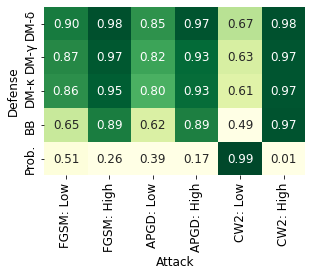

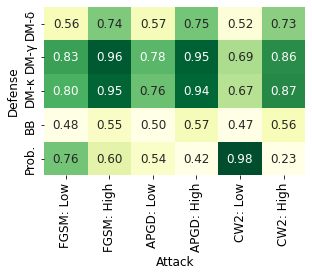

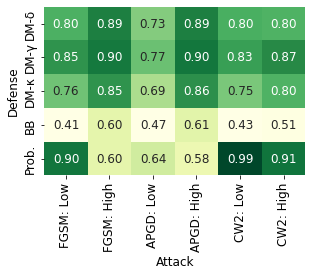

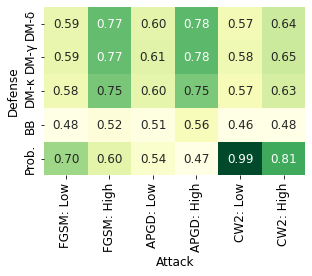

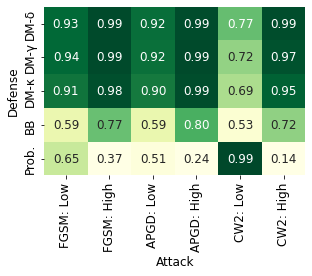

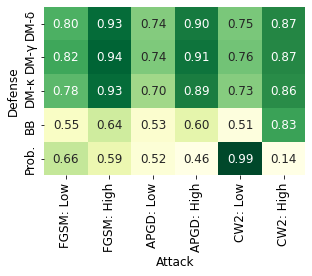

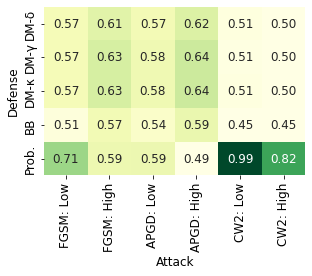

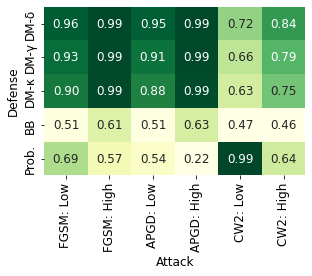

In [15]:
for dataset in DATASETS:
    path_auc_out = os.path.join(PATH_ROOT, 'plot_results', 'numeric', f'{dataset}_auc.pdf')
    create_auc_heatmap(df_results, dataset, path_auc_out)